In [ ]:
import networkx as nx # 图数据挖掘

# 数据分析
import pandas as pd
import numpy as np

import random # 随机数
from tqdm import tqdm # 进度条

# 数据可视化
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签  
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [ ]:
import random
from collections import defaultdict
import os
from sklearn.metrics import roc_auc_score
import random
from gensim.models import Word2Vec
from sklearn.metrics import f1_score

In [ ]:
df = pd.read_csv("p_net_all_4448min.csv")

In [ ]:
G = nx.from_pandas_edgelist(df, "fromNode", "toNode", edge_attr=True, create_using=nx.Graph())

In [ ]:
from node2vec import Node2Vec

In [ ]:
# 设置node2vec参数
node2vec = Node2Vec(G, 
                    dimensions=16,  # 嵌入维度
                    p=1,            # 回家参数
                    q=3,          # 外出参数
                    walk_length=40, # 随机游走最大长度
                    num_walks=100,  # 每个节点作为起始节点生成的随机游走个数
                    workers=2      # 并行线程数
                   )

# p=1, q=0.5, n_clusters=6。DFS深度优先搜索，挖掘同质社群
# p=1, q=2, n_clusters=3。BFS宽度优先搜索，挖掘节点的结构功能。



In [7]:
# 训练Node2Vec，参数文档见 gensim.models.Word2Vec
model = node2vec.fit(window=10,    # Skip-Gram窗口大小
                     min_count=1,  # 忽略出现次数低于此阈值的节点（词）
                     batch_words=4 # 每个线程处理的数据量
                    )
X = model.wv.vectors

In [8]:
# 数据标准化


emb=X
eps = 1e-5
mu = np.mean(emb,axis = 0)
sigma = np.std(emb,axis = 0)
tmp = (emb - mu) / (sigma + eps)

In [9]:
import csv
# 获取节点列表
nodes = list(model.wv.index_to_key)

# 构建节点-特征字典
node_features = {node: features for node, features in zip(nodes, tmp)}

# 指定要保存的文件路径和名称
file_path = "Node2Vec_node_features_16.csv"

# 将节点及其对应的新特征保存为CSV文件
with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # 写入表头，即特征的列名
    writer.writerow(['Node'] + ['Feature{}'.format(i+1) for i in range(len(node_features[nodes[0]]))])
    
    # 写入每个节点及其对应的新特征
    for node, features in node_features.items():
        writer.writerow([node] + features.tolist())


In [10]:
#model.wv.index_to_key

In [16]:
# 将Embedding用PCA降维到2维
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embed_2d = pca.fit_transform(tmp)

# # 将Embedding用TSNE降维到2维
# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, n_iter=5000)
# embed_2d = tsne.fit_transform(X)

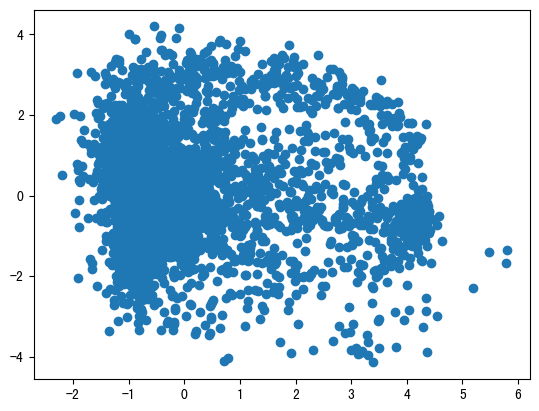

In [17]:
# plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1])
plt.show()

/home/data/t150339/miniconda3/envs/zongjin/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/data/t150339/miniconda3/envs/zongjin/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


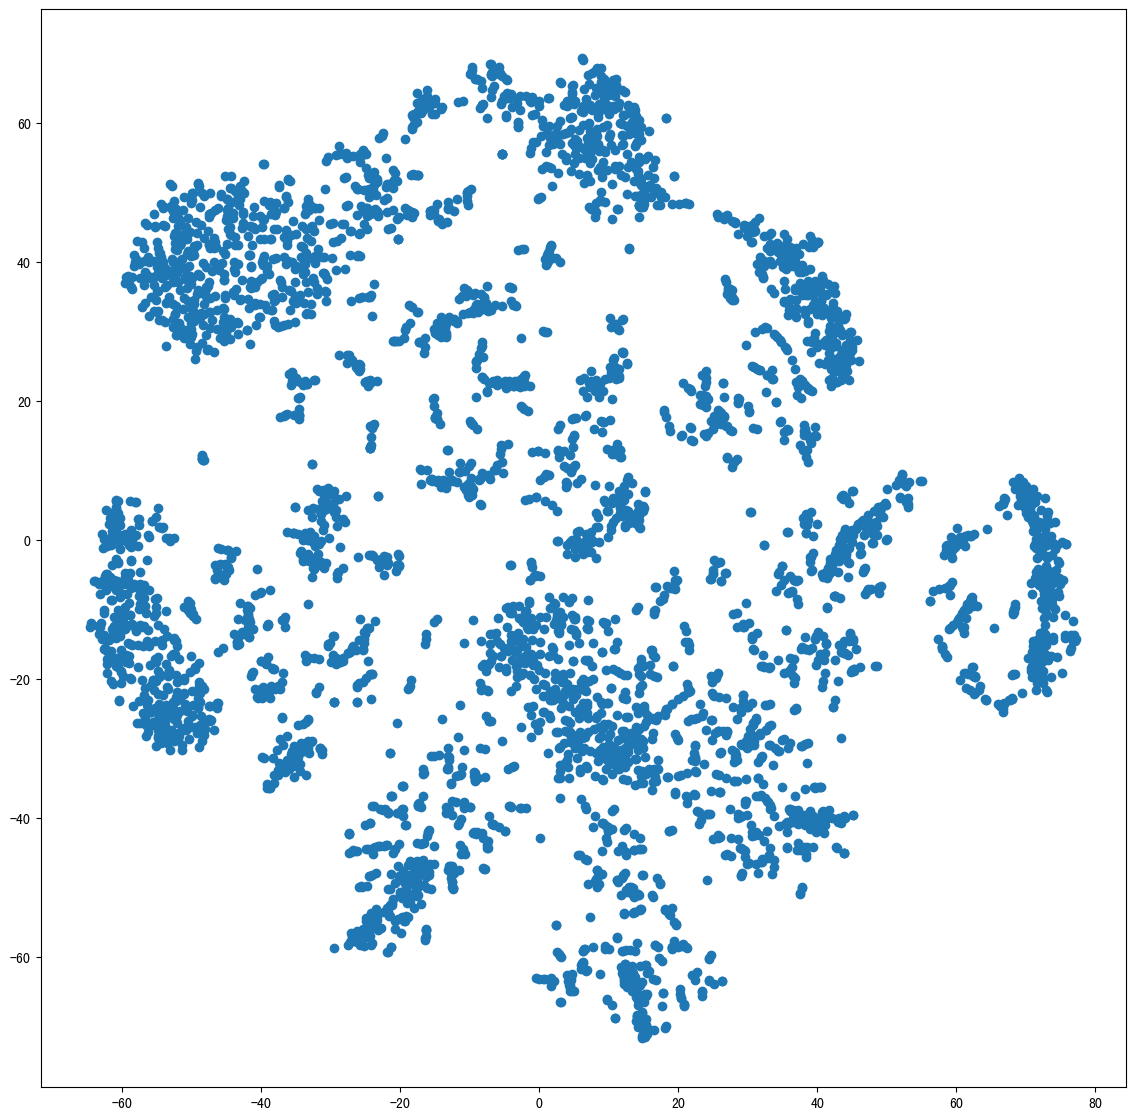

In [18]:
# 将Embedding用TSNE降维到2维
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=1000)
embed_2d = tsne.fit_transform(tmp)
plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1])
plt.show()

In [14]:
similarity_matrix =np.corrcoef(tmp)

In [15]:
similarity_matrix

array([[ 1.        ,  0.91531397,  0.95675088, ...,  0.07102652,
        -0.0786471 ,  0.08535104],
       [ 0.91531397,  1.        ,  0.88490865, ...,  0.16404482,
        -0.04632159, -0.18883556],
       [ 0.95675088,  0.88490865,  1.        , ...,  0.13198117,
        -0.19740988,  0.07223743],
       ...,
       [ 0.07102652,  0.16404482,  0.13198117, ...,  1.        ,
         0.00122126, -0.03764821],
       [-0.0786471 , -0.04632159, -0.19740988, ...,  0.00122126,
         1.        ,  0.26227278],
       [ 0.08535104, -0.18883556,  0.07223743, ..., -0.03764821,
         0.26227278,  1.        ]])

In [19]:
import pandas as pd 
import numpy as np
sim = pd.read_csv('Node2Vec_16_sim_p.csv', index_col=0)  # 使用行名作为索引
Cluster = pd.read_csv('Node2Vec_16_cluster_56.csv', index_col=0)  # 使用行名作为索引
Cluster = Cluster['x'].values.astype(np.int32)

In [20]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# 计算轮廓系数
silhouette = silhouette_score(1-sim,Cluster)

# 计算Calinski-Harabasz指数
calinski_harabasz = calinski_harabasz_score(1-sim,Cluster)

# 计算Davies-Bouldin指数
davies_bouldin = davies_bouldin_score(1-sim, Cluster)

print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski_harabasz)
print("Davies-Bouldin Index:", davies_bouldin)

Silhouette Score: 0.13521940117709308
Calinski-Harabasz Index: 235.1734849877245
Davies-Bouldin Index: 1.7751170598819448


In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np
kmeans = KMeans(n_clusters=56,random_state=111)
clusters = kmeans.fit_predict(1-similarity_matrix)

# 计算轮廓系数
silhouette = silhouette_score(similarity_matrix, clusters)

# 计算Calinski-Harabasz指数
calinski_harabasz = calinski_harabasz_score(similarity_matrix, clusters)

# 计算Davies-Bouldin指数
davies_bouldin = davies_bouldin_score(similarity_matrix, clusters)

print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski_harabasz)
print("Davies-Bouldin Index:", davies_bouldin)

Silhouette Score: 0.18221626110610742
Calinski-Harabasz Index: 297.83074729884885
Davies-Bouldin Index: 1.6707377122397014


In [23]:
from collections import Counter
counter = Counter(clusters)

for element, count in counter.items():
    print(f"Cluster {element} has {count} occurrences")

Cluster 48 has 213 occurrences
Cluster 39 has 153 occurrences
Cluster 46 has 99 occurrences
Cluster 16 has 169 occurrences
Cluster 18 has 82 occurrences
Cluster 4 has 154 occurrences
Cluster 14 has 96 occurrences
Cluster 5 has 81 occurrences
Cluster 6 has 79 occurrences
Cluster 43 has 147 occurrences
Cluster 12 has 72 occurrences
Cluster 34 has 53 occurrences
Cluster 17 has 108 occurrences
Cluster 29 has 83 occurrences
Cluster 3 has 76 occurrences
Cluster 25 has 79 occurrences
Cluster 31 has 79 occurrences
Cluster 40 has 56 occurrences
Cluster 10 has 98 occurrences
Cluster 13 has 95 occurrences
Cluster 33 has 92 occurrences
Cluster 42 has 107 occurrences
Cluster 23 has 97 occurrences
Cluster 52 has 59 occurrences
Cluster 35 has 61 occurrences
Cluster 15 has 54 occurrences
Cluster 21 has 69 occurrences
Cluster 0 has 49 occurrences
Cluster 36 has 50 occurrences
Cluster 27 has 103 occurrences
Cluster 44 has 60 occurrences
Cluster 53 has 34 occurrences
Cluster 47 has 43 occurrences
Cluster

In [24]:
#谱聚类
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
# 使用谱聚类进行聚类
n_clusters = 56 # 聚类的数量

clustering_model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
clusters_SC = clustering_model.fit_predict(similarity_matrix)
# 计算轮廓系数
silhouette = silhouette_score(similarity_matrix, clusters_SC)

# 计算Calinski-Harabasz指数
calinski_harabasz = calinski_harabasz_score(similarity_matrix, clusters_SC)

# 计算Davies-Bouldin指数
davies_bouldin = davies_bouldin_score(similarity_matrix, clusters_SC)

print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski_harabasz)
print("Davies-Bouldin Index:", davies_bouldin)

/home/data/t150339/miniconda3/envs/zongjin/lib/python3.8/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Silhouette Score: 0.13124894581787588
Calinski-Harabasz Index: 205.8708283400102
Davies-Bouldin Index: 1.5869994440370339


In [25]:
from collections import Counter
counter = Counter(clusters_SC)

for element, count in counter.items():
    print(f"Cluster {element} has {count} occurrences")

Cluster 2 has 620 occurrences
Cluster 9 has 186 occurrences
Cluster 0 has 148 occurrences
Cluster 49 has 54 occurrences
Cluster 1 has 242 occurrences
Cluster 8 has 81 occurrences
Cluster 12 has 65 occurrences
Cluster 28 has 150 occurrences
Cluster 5 has 26 occurrences
Cluster 46 has 152 occurrences
Cluster 15 has 57 occurrences
Cluster 40 has 51 occurrences
Cluster 54 has 240 occurrences
Cluster 48 has 34 occurrences
Cluster 45 has 95 occurrences
Cluster 30 has 47 occurrences
Cluster 6 has 67 occurrences
Cluster 33 has 50 occurrences
Cluster 29 has 23 occurrences
Cluster 51 has 51 occurrences
Cluster 21 has 87 occurrences
Cluster 4 has 46 occurrences
Cluster 19 has 91 occurrences
Cluster 35 has 24 occurrences
Cluster 41 has 41 occurrences
Cluster 10 has 50 occurrences
Cluster 44 has 25 occurrences
Cluster 24 has 114 occurrences
Cluster 37 has 41 occurrences
Cluster 20 has 56 occurrences
Cluster 13 has 34 occurrences
Cluster 38 has 44 occurrences
Cluster 22 has 30 occurrences
Cluster 3 